# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu. It is updated weekly and I last downloaded the dataset on 8/10/2020.  



## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis and Visualizations 
    IV. Data Modeling
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder and rape, distributed?</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is update weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
from shapely import speedups
from shapely.geometry import Polygon
import contextily as cxt
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [3]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259648 entries, 0 to 2259647
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20859
Address                             12
Zip Code                         13752
Council District                 46799
APD Sector                        8741
APD District                      9209
PRA                              10430
Census Tract                   1356504
Clearance Status                601857
Clearance Date                  332643
UCR Category                   1492376
Category Description           1492376
X-coordinate                      9844
Y-coordinate                      9844
Latitude                         38096
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

In [4]:
# Helper function to clean the data
def clean_data(df):
    drop_col = ['Occurred Date', 
                'Occurred Time', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate'] 
    df.drop(drop_col, axis=1, inplace=True) 
    clean_col = ['Occurred Date Time', 
                 'Zip Code', 
                 'PRA'] 
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    d = {'Y': True, 'N': False}
    e = {'C': True, 'O': True, 'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence = df.family_violence.map(d)
    df.family_violence = df.family_violence.astype('bool')
    df.zip_code = df.zip_code.astype('int64')
    df.pra = df.pra.astype('int64')
    df.clearance_date = df.clearance_date.astype('datetime64') 
    df.highest_offense_description = df.highest_offense_description.astype('category') 
    df.location_type = df.location_type.astype('category') 
    df.apd_sector = df.apd_sector.astype('category') 
    df.report_date_time = df.report_date_time.astype('datetime64') 
    df['month'] = df['report_date_time'].dt.month
    df.set_index(['report_date_time'], inplace=True) 
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

I recently discovered that after the initial reshaping and cleaning of a dataframe, when beforehand there were none, duplicates will somehow show. So, to be on the safe side, we are going to recheck for duplicates before moving ahead with exploratory analysis. 

In [5]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
occurred_date_time                  0
location_type                   20393
address                             0
zip_code                            0
council_district                33046
apd_sector                          0
apd_district                        0
pra                                 0
clearance_status                    0
clearance_date                 329417
latitude                        27497
longitude                       27497
location                        27497
month                               0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
occurred_date_time                     object
location_type                        category
address                                object
zip_code                                int64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                     int64
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
location                               object
month                                   int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,location,month
report_date_time,,,,,,,,,,,,,,,,,,
2002-11-29 05:30:00,2002923330284,FAMILY DISTURBANCE,3400,False,01/29/2003 05:30:00 AM,RESIDENCE / HOME,6263 MC NEIL DR,78727,6.0,AD,3,183,False,NaT,30.441398,-97.747483,"(30.44139787, -97.74748262)",11
2003-01-01 00:01:00,2003920010029,DEADLY CONDUCT,408,False,01/01/2003 12:01:00 AM,RESIDENCE / HOME,6400 CHIMNEY CREEK CIR,78723,1.0,ID,4,297,False,NaT,30.312100,-97.678260,"(30.31209986, -97.67825959)",1
2003-01-01 00:02:00,2003920010046,BURGLARY NON RESIDENCE,502,False,01/01/2003 12:02:00 AM,COMMERCIAL / OFFICE BUILDING,730 W STASSNEY LN,78745,2.0,DA,3,511,True,2003-10-18,30.209853,-97.782088,"(30.2098532, -97.78208826)",1
2003-01-01 00:03:00,2003920010048,DEADLY CONDUCT,408,False,01/01/2003 12:03:00 AM,RESIDENCE / HOME,1521 REAGAN HILL DR,78752,4.0,ID,2,266,True,2003-01-02,30.325735,-97.689095,"(30.32573466, -97.68909512)",1
2003-01-01 00:06:00,2003920010079,RESISTING ARREST OR SEARCH,905,False,01/01/2003 12:06:00 AM,RESIDENCE / HOME,2407 CORONADO ST,78702,3.0,CH,2,422,True,2003-01-01,30.261713,-97.713550,"(30.26171331, -97.71354969)",1


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,location,month
report_date_time,,,,,,,,,,,,,,,,,,
2020-08-15 19:31:00,20205031958,CRIMINAL MISCHIEF,1400,False,08/14/2020 08:00:00 PM,PARKING LOTS / GARAGE,1071 CLAYTON LN,78723,4.0,ID,5,292,True,NaT,30.318529,-97.703422,"(30.3185291, -97.7034222)",8
2020-08-15 19:46:00,20205031959,THEFT,600,False,06/15/2020 06:00:00 AM,RESIDENCE / HOME,7400 BLUE GOOSE RD,78653,NaN,CH,8,765,True,NaT,30.341265,-97.610045,"(30.34126454, -97.61004475)",8
2020-08-15 21:00:00,20205031963,BURGLARY OF VEHICLE,601,False,08/15/2020 07:10:00 PM,OTHER / UNKNOWN,5000 PLAZA ON THE LAKE,78746,10.0,BA,8,305,True,NaT,30.349106,-97.801580,"(30.34910565, -97.80158005)",8
2020-08-15 21:23:00,20205031965,BURGLARY OF VEHICLE,601,False,08/15/2020 06:45:00 PM,PARKING LOTS / GARAGE,5000 PLAZA ON THE LAKE,78746,10.0,BA,8,305,True,NaT,30.349106,-97.801580,"(30.34910565, -97.80158005)",8
2020-08-15 23:32:00,20202280937,POSS CONTROLLED SUB/SYN NARC,1801,False,08/15/2020 03:55:00 PM,STREETS / HWY / ROAD / ALLEY,AIRPORT BLVD / MANOR RD,78723,1.0,BA,4,900,True,NaT,30.286292,-97.706367,"(30.28629196, -97.70636683)",8


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

78741    203483
78753    175160
78701    166560
78758    155862
78704    152061
78745    148147
78702    135096
78744    123995
78723    116250
78752     83192
78748     66618
78759     64847
78751     62986
78757     56651
78705     56001
78721     46955
78749     39735
78724     36978
78727     35144
78703     34607
78731     27967
78746     27753
78729     25040
78750     23107
78754     22112
78722     19449
78756     17835
78617     16860
78735     15347
78747     12850
          ...  
78730      2992
78653      1823
78728      1376
78652       678
78664       369
78712       334
78733       319
78732       295
78737       212
78681       210
78610       130
78734       102
78641        66
0            62
78738        43
78621        28
78645        24
78620        17
76574        17
78640        16
78713        12
78612        11
78669         9
78634         5
78615         4
78626         3
78642         2
78619         1
78654         1
78628         1
Name: zip_code, Length: 

----------------------------------


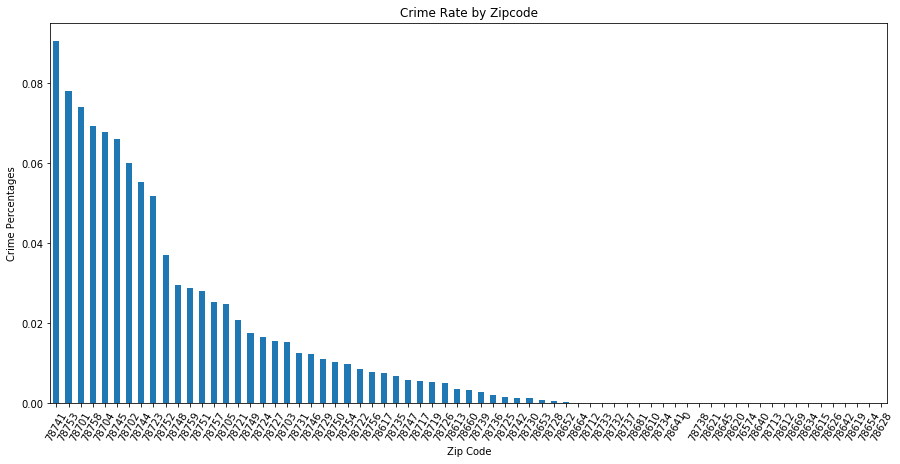

highest_offense_description,ABANDONED REFRIGERATOR,ABUSE OF 911,ABUSE OF CORPSE,ABUSE OF OFFICIAL CAPACITY,AGG ASLT ENHANC STRANGL/SUFFOC,AGG ASLT STRANGLE/SUFFOCATE,AGG ASLT W/MOTOR VEH FAM/DAT V,AGG ASSAULT,AGG ASSAULT FAM/DATE VIOLENCE,AGG ASSAULT ON PEACE OFFICER,AGG ASSAULT ON PUBLIC SERVANT,AGG ASSAULT WITH MOTOR VEH,AGG FORCED SODOMY,AGG FORCED SODOMY OF CHILD,AGG KIDNAPPING,AGG KIDNAPPING FAM VIO,AGG PERJURY,AGG PROMOTION OF PROSTITUTION,AGG RAPE,AGG RAPE OF A CHILD,AGG ROBBERY BY ASSAULT,AGG ROBBERY/DEADLY WEAPON,AGG SEXUAL ASSAULT CHILD/OBJEC,AGG SEXUAL ASSAULT W OBJECT,AGG SODOMY,AIDING SUICIDE,AIRPORT - BOMB THREAT,AIRPORT - BREACH OF SECURITY,AIRPORT - CRIMINAL TRESPASS,AIRPORT - FEDERAL VIOL,AIRPORT - SUSPICIOUS PERSON,AIRPORT PLACES WEAPON PROHIBIT,AMPLIFIED MUSIC / VEHICLE,APPLIC TO REVOKE PROBATION,ARSON,ARSON WITH BODILY INJURY,ASSAULT CONTACT-SEXUAL NATURE,ASSAULT - SCHOOL PERSONNEL,ASSAULT BY CONTACT,ASSAULT BY CONTACT FAM/DATING,ASSAULT BY THREAT,ASSAULT BY THREAT FAM/DATING,ASSAULT OF A PREGNANT WOMAN,ASSAULT OF PREGNANT WM-FAM/DAT,ASSAULT ON PEACE OFFICER,ASSAULT ON PUBLIC SERVANT,ASSAULT W/INJURY-FAM/DATE VIOL,ASSAULT WITH INJURY,ATT ARSON,ATT AUTO THEFT,ATT BURGLARY NON RESIDENCE,ATT BURGLARY OF RESIDENCE,ATT THEFT,ATTACK ON ASSISTANCE ANIMAL,AUTO THEFT,AWOL,BAIL JUMPING/FAIL TO APPEAR,BANK KITING,BESTIALITY,BOATING WHILE INTOXICATED,BOMB THREAT,BOMB THREAT - AIRCRAFT,BREACH OF COMPUTER SECURITY,BRIBERY,BURG NON RESIDENCE SHEDS,BURG OF RES - FAM/DATING ASLT,BURG OF RES - SEXUAL NATURE,BURGLARY NON RESIDENCE,BURGLARY OF COIN-OP MACHINE,BURGLARY OF RESIDENCE,BURGLARY OF VEHICLE,BWI-EXPIRED USE 2110,CAMPING IN PARK,CAPITAL MURDER,CHILD CUSTODY INTERFERE,CHILD ENDANGERMENT- ABANDONMEN,CIVIL DISTURBANCE/DEMO,COERCION OF PUBLIC SERVANT,COMMERCIAL BRIBERY,COMMUNICATING GAMBLING INFO,COMPELLING PROSTITUTION,CONT SEX ABUSE OF CHILD,CONTEMPT OF COURT,CONTRIBUTE DELINQUENCY MINOR,CONTROLLED SUB VIOL - OTHER,COUNTERFEITING,CRASH/FAIL STOP AND RENDER AID,CRASH/INTOX MANSLAUGHTER,CRASH/INTOXICATION ASSAULT,CRASH/MANSLAUGHTER,CRASH/MURDER,CRASH/NEGLIGENT HOMICIDE,CRED CARD ABUSE - EXPIR-CANCEL,CRED CARD ABUSE - OTHER,CRED CARD ABUSE BY FORGERY,CRIM NEG HOMICIDE/NON TRAFFIC,CRIMES AGAINST ELDERLY,CRIMINAL CONSPIRACY,CRIMINAL MISCHIEF,CRIMINAL MISCHIEF BY ARSON,CRIMINAL NONSUPPORT,CRIMINAL SOLICITATION,CRIMINAL SOLICITATION OF MINOR,CRIMINAL TRESPASS,CRIMINAL TRESPASS/HOTEL,CRIMINAL TRESPASS/IN VEHICLE,CRIMINAL TRESPASS/TRANSIENT,CRUELTY TO ANIMALS,CUSTODY ARREST TRAFFIC WARR,DAMAGE CITY PROP,DAMAGE CITY VEHICLE,DANG DRUG VIOL - OTHER,DATING DISTURBANCE,DEADLY CONDUCT,DEADLY CONDUCT FAM/DATE VIOL,DEBIT CARD ABUSE,DEL CONTROLLED SUB/NARCOTIC,DEL CONTROLLED SUB/OTHER,DEL CONTROLLED SUB/SYN NARC,DEL MARIJUANA,DEL OF ALCOHOL TO MINOR,DEL OF DANG DRUG,DEL SYNTHETIC MARIJUANA,DELIVERY OF PRESCRIPTION FORM,DEPENDENT AND NEGLECTED CHILD,DESECRATION VENERATED OBJECT,DESERTION,DISCLOSE/PROMO INTIMATE VISUAL,DISPOSAL OF SOLID WASTE,DISRUPTING MEETING/PROCESSION,DISRUPTION OF CLASSES,DISRUPTIVE ACTS AT SCHOOLS,DISTRIB HARMFUL MATERIAL MINOR,DISTURBANCE - OTHER,DOC ABUSE OR THREAT,DOC ABUSIVE LANGUAGE,DOC CREATING NOXIOUS ODOR,DOC DISCHARGE GUN - PUB PLACE,DOC DISCHARGE GUN - PUB ROAD,DOC DISPLAY GUN/DEADLY PUB PLC,DOC EXPOSURE,DOC FIGHTING,DOC OFFENSIVE GESTURE,DOC UNREASONABLE NOISE,DOC WINDOW PEEPING - HOTEL,DOC WINDOW PEEPING - PUB AREA,DOC WINDOW PEEPING-RESIDENCE,DOMESTIC VIOLENCE/ALARM,DRINKING AFTER CURFEW,DRIVING WHILE INTOX / FELONY,DUI - AGE 16 AND UNDER,DUI - AGE 17 TO 20,DUMPING REFUSE NEAR HIGHWAY,DWI,DWI .15 BAC OR ABOVE,DWI - CHILD PASSENGER,DWI - DRUG RECOGNITION EXPERT,DWI 2ND,ENTICING A CHILD,ESCAPE FROM CUSTODY,EVADING / FOOT,EVADING / VEHICLE PURSUIT,EVADING VEHICLE,EXP-VIOL CITY ORDINANCE - TAXI,EXPIRED - DEADLY ASSAULT,EXPIRED-ATT AGG KIDNAPPING,EXPIRED-ATT AGG ROBBERY/WEAP,EXPIRED-ATT AGG SEXUAL ASSAULT,EXPIRED-ATT CAPITAL MURDER,EXPIRED-ATT FORCED SODOMY,EXPIRED-ATT KIDNAPPING,EXPIRED-ATT MURDER,EXPIRED-ATT

In [21]:
color = ['green', 'blue', 'red', 'yellow', 'purple', 'cyan', 'gold', 'black', 'pink']


# Create and show dataframe for crime rates by zipcode
zip_codes = df.zip_code.value_counts()
display(zip_codes)

# Showing the results as percentages
print('----------------------------------')
df.zip_code.value_counts(normalize=True).plot.bar(figsize=(15,7), 
                                                            rot=60)

plt.xlabel('Zip Code')
plt.ylabel('Crime Percentages')
plt.title('Crime Rate by Zipcode')
plt.show()

zip_off_desc = pd.crosstab(df.zip_code, df.highest_offense_description)
display(zip_off_desc)                        

In [8]:
zip_off_desc.to_csv('zip_off_desc.csv')

In [9]:
df.highest_offense_description.value_counts(normalize=True)

BURGLARY OF VEHICLE               1.013237e-01
THEFT                             9.248383e-02
FAMILY DISTURBANCE                7.746201e-02
CRIMINAL MISCHIEF                 5.539171e-02
ASSAULT W/INJURY-FAM/DATE VIOL    3.403076e-02
BURGLARY OF RESIDENCE             3.393502e-02
DWI                               3.036202e-02
PUBLIC INTOXICATION               3.027475e-02
HARASSMENT                        2.790581e-02
DISTURBANCE - OTHER               2.678502e-02
CUSTODY ARREST TRAFFIC WARR       2.195052e-02
THEFT BY SHOPLIFTING              2.108755e-02
ASSAULT WITH INJURY               2.067788e-02
WARRANT ARREST NON TRAFFIC        1.895016e-02
AUTO THEFT                        1.827020e-02
RUNAWAY CHILD                     1.813350e-02
CRIMINAL TRESPASS                 1.670679e-02
POSSESSION OF MARIJUANA           1.594001e-02
BURGLARY NON RESIDENCE            1.517099e-02
POSS OF DRUG PARAPHERNALIA        1.496527e-02
POSS CONTROLLED SUB/NARCOTIC      1.415128e-02
ASSAULT BY CO

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.06%. This is a significant 1.3 percentage points higher than the number 2 area 78753 which hosts 7.8% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16883
BURGLARY OF VEHICLE               15704
FAMILY DISTURBANCE                14267
CRIMINAL MISCHIEF                  9215
THEFT BY SHOPLIFTING               7492
ASSAULT W/INJURY-FAM/DATE VIOL     7009
BURGLARY OF RESIDENCE              5995
DWI                                4835
DISTURBANCE - OTHER                4667
CUSTODY ARREST TRAFFIC WARR        4314
HARASSMENT                         4138
AUTO THEFT                         4036
POSS OF DRUG PARAPHERNALIA         3708
PUBLIC INTOXICATION                3338
ASSAULT WITH INJURY                3225
CRIMINAL TRESPASS                  3091
POSS CONTROLLED SUB/NARCOTIC       2927
RUNAWAY CHILD                      2885
WARRANT ARREST NON TRAFFIC         2778
POSSESSION OF MARIJUANA            2679
BURGLARY NON RESIDENCE             2433
VIOL CITY ORDINANCE - OTHER        1860
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096386
BURGLARY OF VEHICLE               0.089655
FAMILY DISTURBANCE                0.081451
CRIMINAL MISCHIEF                 0.052609
THEFT BY SHOPLIFTING              0.042772
ASSAULT W/INJURY-FAM/DATE VIOL    0.040015
BURGLARY OF RESIDENCE             0.034226
DWI                               0.027603
DISTURBANCE - OTHER               0.026644
CUSTODY ARREST TRAFFIC WARR       0.024629
HARASSMENT                        0.023624
AUTO THEFT                        0.023042
POSS OF DRUG PARAPHERNALIA        0.021169
PUBLIC INTOXICATION               0.019057
ASSAULT WITH INJURY               0.018412
CRIMINAL TRESPASS                 0.017647
POSS CONTROLLED SUB/NARCOTIC      0.016710
RUNAWAY CHILD                     0.016471
WARRANT ARREST NON TRAFFIC        0.015860
POSSESSION OF MARIJUANA           0.015295
BURGLARY NON RESIDENCE            0.013890
VIOL CITY ORDINANCE - OTHER       0.010619
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78753)')

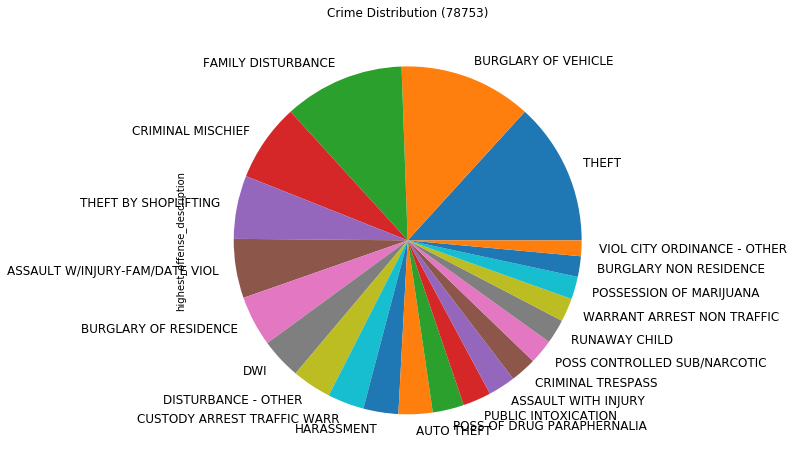

In [10]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(fontsize=12,
                   figsize=(8,8))
plt.title('Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                19931
BURGLARY OF VEHICLE               19588
THEFT                             15366
CRIMINAL MISCHIEF                 10861
ASSAULT W/INJURY-FAM/DATE VIOL     9528
BURGLARY OF RESIDENCE              8772
PUBLIC INTOXICATION                6354
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5598
HARASSMENT                         5404
DISTURBANCE - OTHER                5078
AUTO THEFT                         4466
ASSAULT WITH INJURY                4464
CRIMINAL TRESPASS                  3827
POSS CONTROLLED SUB/NARCOTIC       3814
POSSESSION OF MARIJUANA            3780
THEFT BY SHOPLIFTING               3542
POSS OF DRUG PARAPHERNALIA         3514
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2766
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.097949
BURGLARY OF VEHICLE               0.096264
THEFT                             0.075515
CRIMINAL MISCHIEF                 0.053375
ASSAULT W/INJURY-FAM/DATE VIOL    0.046825
BURGLARY OF RESIDENCE             0.043109
PUBLIC INTOXICATION               0.031226
CUSTODY ARREST TRAFFIC WARR       0.029541
DWI                               0.027511
HARASSMENT                        0.026558
DISTURBANCE - OTHER               0.024955
AUTO THEFT                        0.021948
ASSAULT WITH INJURY               0.021938
CRIMINAL TRESPASS                 0.018807
POSS CONTROLLED SUB/NARCOTIC      0.018744
POSSESSION OF MARIJUANA           0.018576
THEFT BY SHOPLIFTING              0.017407
POSS OF DRUG PARAPHERNALIA        0.017269
WARRANT ARREST NON TRAFFIC        0.016945
RUNAWAY CHILD                     0.013593
VIOL CITY ORDINANCE - OTHER       0.010787
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78741)')

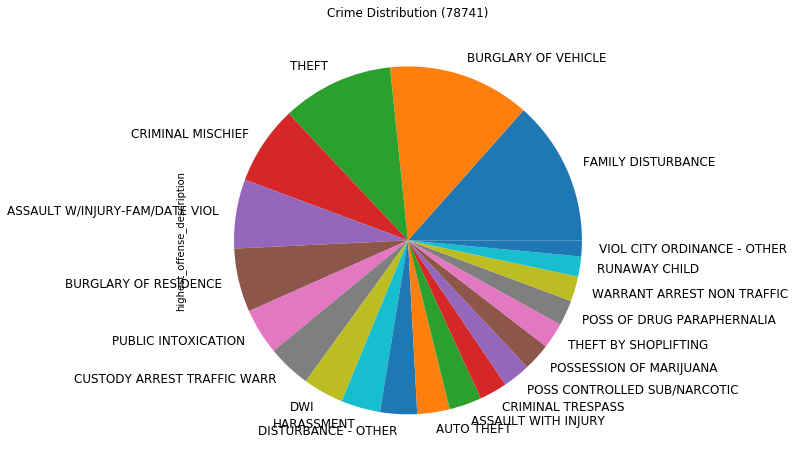

In [11]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8), 
                   fontsize=12)
plt.title('Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, and rape, distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

78741    2149
78701    1830
78753    1710
78758    1543
78702    1395
78723    1259
78745    1102
78744    1002
78704     950
78752     867
78721     590
78724     518
78705     472
78757     364
78748     346
78751     322
78759     234
78749     163
78617     159
78722     155
78754     145
78729     144
78727     143
78750     104
78731     104
78756     102
78735      96
78703      91
78747      86
78660      83
78746      70
78726      69
78717      48
78742      46
78725      33
78736      28
78613      21
78730      21
78728      12
78739      12
78719      11
78653      10
78737       4
78664       3
78712       2
78732       2
78681       2
78652       2
78610       1
78634       1
78733       1
78621       1
78738       1
Name: zip_code, dtype: int64

78741    0.115358
78701    0.098234
78753    0.091792
78758    0.082828
78702    0.074883
78723    0.067583
78745    0.059155
78744    0.053787
78704    0.050996
78752    0.046540
78721    0.031671
78724    0.027806
78705    0.025337
78757    0.019539
78748    0.018573
78751    0.017285
78759    0.012561
78749    0.008750
78617    0.008535
78722    0.008320
78754    0.007784
78729    0.007730
78727    0.007676
78750    0.005583
78731    0.005583
78756    0.005475
78735    0.005153
78703    0.004885
78747    0.004616
78660    0.004455
78746    0.003758
78726    0.003704
78717    0.002577
78742    0.002469
78725    0.001771
78736    0.001503
78613    0.001127
78730    0.001127
78728    0.000644
78739    0.000644
78719    0.000590
78653    0.000537
78737    0.000215
78664    0.000161
78712    0.000107
78732    0.000107
78681    0.000107
78652    0.000107
78610    0.000054
78634    0.000054
78733    0.000054
78621    0.000054
78738    0.000054
Name: zip_code, dtype: float64

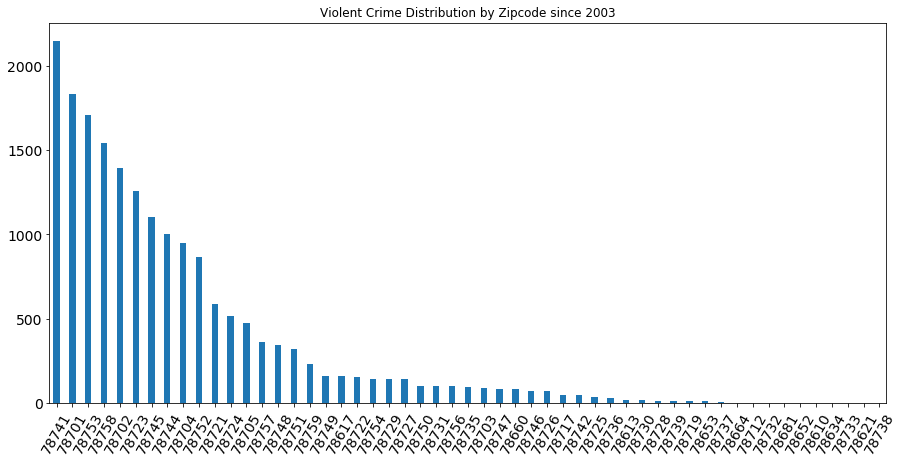

In [12]:
df_viol = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')

df_viol_zip = df_viol.zip_code.value_counts()
display(df_viol_zip)
display(df_viol.zip_code.value_counts(normalize=True))

df_viol_zip.plot.bar(rot=60,
                     width=0.4,
                     figsize=(15,7),
                     fontsize=14)
plt.title('Violent Crime Distribution by Zipcode since 2003')
plt.show()

----------------------------------
Murder
----------------------------------


78741    42
78753    40
78758    36
78723    33
78744    27
78702    24
78752    21
78745    20
78704    16
78701    16
78721    13
78724    12
78749    10
78751     8
78617     6
78757     6
78705     6
78759     6
78754     5
78727     5
78748     4
78747     4
78750     4
78731     4
78735     3
78729     2
78742     2
78746     2
78660     2
78756     2
78717     1
78728     1
78653     1
78613     1
Name: zip_code, dtype: int64

----------------------------------


78741    0.109091
78753    0.103896
78758    0.093506
78723    0.085714
78744    0.070130
78702    0.062338
78752    0.054545
78745    0.051948
78704    0.041558
78701    0.041558
78721    0.033766
78724    0.031169
78749    0.025974
78751    0.020779
78617    0.015584
78757    0.015584
78705    0.015584
78759    0.015584
78754    0.012987
78727    0.012987
78748    0.010390
78747    0.010390
78750    0.010390
78731    0.010390
78735    0.007792
78729    0.005195
78742    0.005195
78746    0.005195
78660    0.005195
78756    0.005195
78717    0.002597
78728    0.002597
78653    0.002597
78613    0.002597
Name: zip_code, dtype: float64

----------------------------------
Capital Murder
----------------------------------


78723    11
78753    11
78758     8
78741     7
78752     6
78745     6
78744     4
78721     3
78748     3
78702     3
78724     2
78727     2
78705     2
78704     2
78757     2
78754     1
78731     1
78759     1
78701     1
78703     1
78722     1
78749     1
Name: zip_code, dtype: int64

----------------------------------


78723    0.139241
78753    0.139241
78758    0.101266
78741    0.088608
78752    0.075949
78745    0.075949
78744    0.050633
78721    0.037975
78748    0.037975
78702    0.037975
78724    0.025316
78727    0.025316
78705    0.025316
78704    0.025316
78757    0.025316
78754    0.012658
78731    0.012658
78759    0.012658
78701    0.012658
78703    0.012658
78722    0.012658
78749    0.012658
Name: zip_code, dtype: float64

----------------------------------
Rape
----------------------------------


78741    499
78753    357
78701    352
78758    310
78745    273
78704    242
78705    205
78744    203
78723    196
78702    181
78752    140
78748    112
78751    110
78759    103
78757     81
78721     73
78724     65
78729     55
78749     53
78731     52
78754     47
78727     41
78722     39
78756     38
78617     36
78703     35
78726     35
78750     31
78746     29
78747     27
78660     17
78717     12
78725     11
78735     11
78736      9
78742      8
78730      8
78613      6
78739      5
78728      4
78737      2
78719      1
78712      1
78732      1
78681      1
78653      1
Name: zip_code, dtype: int64

----------------------------------


78741    0.121175
78753    0.086693
78701    0.085478
78758    0.075279
78745    0.066294
78704    0.058766
78705    0.049781
78744    0.049296
78723    0.047596
78702    0.043953
78752    0.033997
78748    0.027198
78751    0.026712
78759    0.025012
78757    0.019670
78721    0.017727
78724    0.015784
78729    0.013356
78749    0.012870
78731    0.012627
78754    0.011413
78727    0.009956
78722    0.009471
78756    0.009228
78617    0.008742
78703    0.008499
78726    0.008499
78750    0.007528
78746    0.007042
78747    0.006557
78660    0.004128
78717    0.002914
78725    0.002671
78735    0.002671
78736    0.002186
78742    0.001943
78730    0.001943
78613    0.001457
78739    0.001214
78728    0.000971
78737    0.000486
78719    0.000243
78712    0.000243
78732    0.000243
78681    0.000243
78653    0.000243
Name: zip_code, dtype: float64

----------------------------------
Aggrivated Assault
----------------------------------


78741    1601
78701    1461
78753    1302
78758    1189
78702    1187
78723    1019
78745     803
78744     768
78752     700
78704     690
78721     501
78724     439
78757     275
78705     259
78748     227
78751     204
78759     124
78617     117
78722     115
78749      99
78727      95
78754      92
78729      87
78735      82
78750      69
78660      64
78756      62
78703      55
78747      55
78731      47
78746      39
78742      36
78717      35
78726      34
78725      22
78736      19
78613      14
78730      13
78719      10
78653       8
78728       7
78739       7
78664       3
78652       2
78737       2
78732       1
78621       1
78681       1
78610       1
78634       1
78738       1
78712       1
78733       1
Name: zip_code, dtype: int64

----------------------------------


78741    0.113975
78701    0.104008
78753    0.092689
78758    0.084644
78702    0.084502
78723    0.072542
78745    0.057165
78744    0.054674
78752    0.049833
78704    0.049121
78721    0.035666
78724    0.031252
78757    0.019577
78705    0.018438
78748    0.016160
78751    0.014523
78759    0.008828
78617    0.008329
78722    0.008187
78749    0.007048
78727    0.006763
78754    0.006549
78729    0.006193
78735    0.005838
78750    0.004912
78660    0.004556
78756    0.004414
78703    0.003915
78747    0.003915
78731    0.003346
78746    0.002776
78742    0.002563
78717    0.002492
78726    0.002420
78725    0.001566
78736    0.001353
78613    0.000997
78730    0.000925
78719    0.000712
78653    0.000570
78728    0.000498
78739    0.000498
78664    0.000214
78652    0.000142
78737    0.000142
78732    0.000071
78621    0.000071
78681    0.000071
78610    0.000071
78634    0.000071
78738    0.000071
78712    0.000071
78733    0.000071
Name: zip_code, dtype: float64

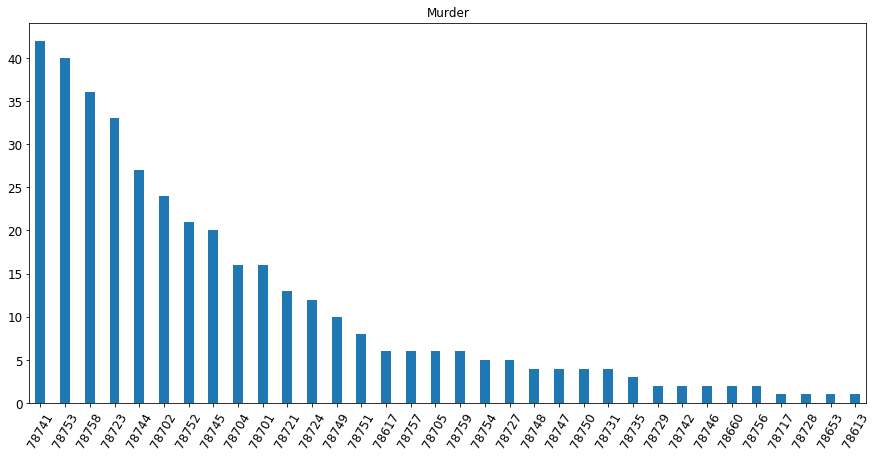

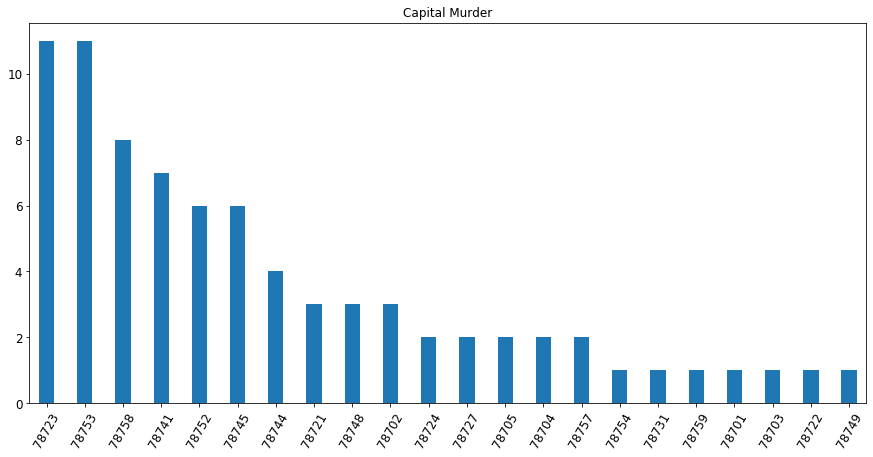

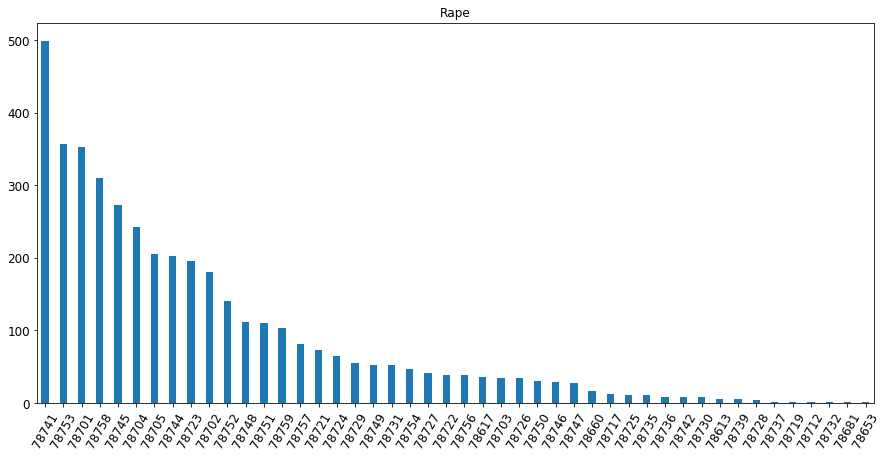

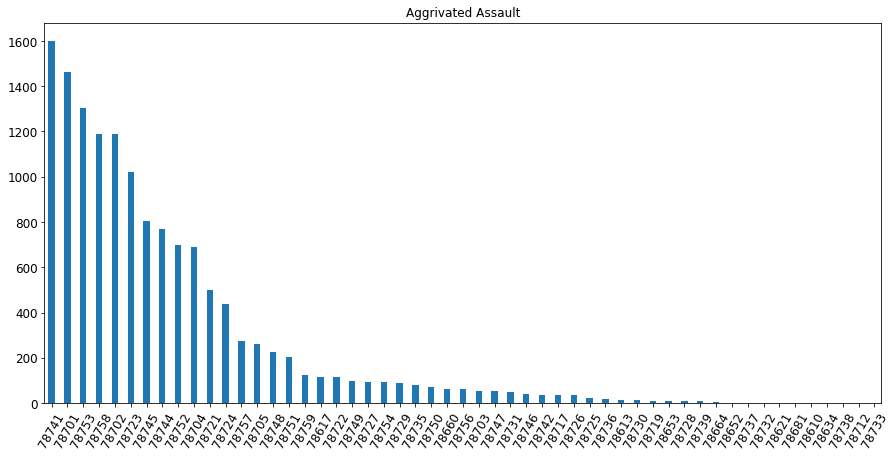

In [13]:
# Create a dataframe for murders, capital murders, and rapes
df_mur = df[df.highest_offense_description == 'MURDER']
df_mur_cap = df[df.highest_offense_description == 'CAPITAL MURDER']
df_rape = df[df.highest_offense_description == 'RAPE']
df_agg_asslt = df[df.highest_offense_description == 'AGG ASSAULT']

# What are the top zipcodes for murders? 
print('----------------------------------')
print('Murder')
print('----------------------------------')
df_mur_val = df_mur.zip_code.value_counts()
display(df_mur_val)
print('----------------------------------')
display(df_mur.zip_code.value_counts(normalize=True))

# What are the top zipcodes for capital murders? 
print('----------------------------------')
print('Capital Murder')
print('----------------------------------')
df_mur_cap_val = df_mur_cap.zip_code.value_counts()
display(df_mur_cap_val)
print('----------------------------------')
display(df_mur_cap.zip_code.value_counts(normalize=True))

# What are the top 10 zipcodes for rape? 
print('----------------------------------')
print('Rape')
print('----------------------------------')
df_rape_val = df_rape.zip_code.value_counts()
display(df_rape_val)
print('----------------------------------')
display(df_rape.zip_code.value_counts(normalize=True))

print('----------------------------------')
print('Aggrivated Assault')
print('----------------------------------')
df_agg_asslt_val = df_agg_asslt.zip_code.value_counts()
display(df_agg_asslt_val)
print('----------------------------------')
display(df_agg_asslt.zip_code.value_counts(normalize=True))
        

df_mur_val.plot.bar(figsize=(15,7),
                    rot=60,
                    width=0.4,
                    fontsize=12)
plt.title('Murder')
plt.show()

df_mur_cap_val.plot.bar(figsize=(15,7),
                        rot=60, 
                        width=0.4,
                        fontsize=12)
plt.title('Capital Murder')
plt.show()

df_rape_val.plot.bar(figsize=(15,7),
                     rot=60, 
                     width=0.4,
                     fontsize=12)
plt.title('Rape')
plt.show()

df_agg_asslt_val.plot.bar(figsize=(15,7),
                          rot=60, 
                          width=0.4,
                          fontsize=12)
plt.title('Aggrivated Assault')
plt.show()

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610,1,0,0,0
78613,14,0,1,6
78617,117,0,6,36
78621,1,0,0,0
78634,1,0,0,0
78652,2,0,0,0
78653,8,0,1,1
78660,64,0,2,17
78664,3,0,0,0


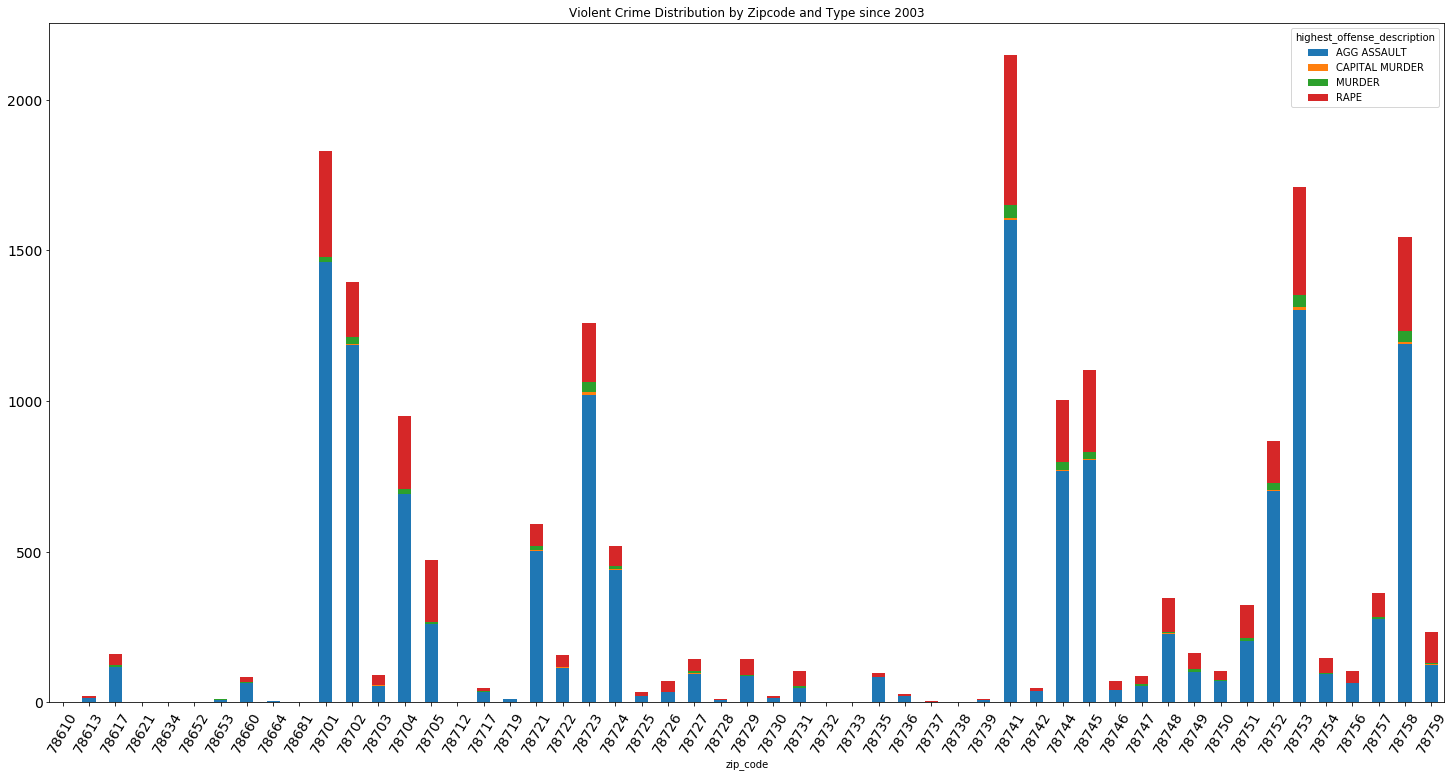

In [26]:
viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
display(viol_freq)

viol_freq.plot.bar(figsize=(25,12.5),
                  stacked=True,
                  rot=60,
                  fontsize=14)
plt.title('Violent Crime Distribution by Zipcode and Type since 2003')
plt.show()

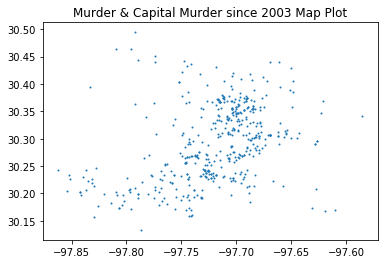

In [25]:
fig, ax = plt.subplots()
ax.plot(df_viol_mur['longitude'], 
        df_viol_mur['latitude'], 
        'o', 
        markersize=1)
plt.title('Murder & Capital Murder since 2003 Map Plot')
plt.show()

Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%.

So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

What also stands out zipcode 78731. Although violent crime frequencies are among the lowest, it has an enormously higher percentage of rape crimes than any other zipcode (over 50%). In fact, rape occurs at a higher percentage in that zipcode than aggrivated assault. Why is that? 

Breaking down violent crime by month, we see that May has the most number of aggrivated assaults, while June sees the most number of rapes, and July sees the most non-capital murders. For capital murders, November is the month when they are most likely to occur. 